# Étape 2 : Évaluation du modèle de base (AVANT fine-tuning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import warnings
warnings.filterwarnings('ignore')

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Device utilisé: {device}")

# Mapping des labels pour Allociné (binaire)
label_mapping = {0: 'Négatif', 1: 'Positif'}
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

 Device utilisé: cuda


In [2]:


# ============================================================================
# CHARGEMENT DES DONNÉES ALLOCINÉ
# ============================================================================

print("\n" + "="*60)
print(" CHARGEMENT DES DONNÉES ALLOCINÉ")
print("="*60)

# Charger les données de l'étape précédente
try:
    train_df = pd.read_csv('train_data_allocine.csv')
    test_df = pd.read_csv('test_data_allocine.csv')
    print(f" Données Allociné chargées avec succès !")
    print(f"   Train: {len(train_df)} avis")
    print(f"   Test: {len(test_df)} avis")
except FileNotFoundError:
    print(" Erreur: Fichiers de données Allociné non trouvés.")
    raise

# Aperçu des données de test qu'on va évaluer
print(f"\n Aperçu des données de test :")
print(test_df.head())

# Statistiques sur les données
print(f"\n Statistiques des données :")
print(f"   Longueur moyenne train: {train_df['text'].str.len().mean():.0f} caractères")
print(f"   Longueur moyenne test: {test_df['text'].str.len().mean():.0f} caractères")
print(f"   Mots moyens train: {train_df['text'].str.split().str.len().mean():.1f}")
print(f"   Mots moyens test: {test_df['text'].str.split().str.len().mean():.1f}")

# Distribution des classes
print(f"\n Distribution des classes :")
train_dist = train_df['label'].value_counts().sort_index()
test_dist = test_df['label'].value_counts().sort_index()

for label_id in [0, 1]:
    train_count = train_dist.get(label_id, 0)
    test_count = test_dist.get(label_id, 0)
    train_pct = train_count / len(train_df) * 100
    test_pct = test_count / len(test_df) * 100
    print(f"   {label_mapping[label_id]}: Train {train_count} ({train_pct:.1f}%) | Test {test_count} ({test_pct:.1f}%)")


 CHARGEMENT DES DONNÉES ALLOCINÉ
 Données Allociné chargées avec succès !
   Train: 2000 avis
   Test: 400 avis

 Aperçu des données de test :
                                                text  label
0  Que c’est mauvais. Un film faussement cynique ...      0
1  Navrant, désolant, pas crédible. Du pur politi...      0
2  Bon c'est pas un grand film mais on passe un b...      1
3  Une comédie policière tout à fait prévisible q...      0
4  Film cultissime de Disney, May Poppins a marqu...      1

 Statistiques des données :
   Longueur moyenne train: 544 caractères
   Longueur moyenne test: 554 caractères
   Mots moyens train: 91.2
   Mots moyens test: 93.6

 Distribution des classes :
   Négatif: Train 1000 (50.0%) | Test 200 (50.0%)
   Positif: Train 1000 (50.0%) | Test 200 (50.0%)


In [3]:
# ============================================================================
# CHARGEMENT DU MODÈLE PRÉ-ENTRAÎNÉ
# ============================================================================

print("\n" + "="*60)
print(" CHARGEMENT DU MODÈLE DE BASE")
print("="*60)

# On va tester plusieurs modèles pour comparaison
models_to_test = [
    "distilbert-base-multilingual-cased",
    "camembert-base"  # Modèle français spécialisé
]

# Commencer par DistilBERT multilingue
model_name = "distilbert-base-multilingual-cased"
print(f" Chargement de {model_name}...")

try:
    # Charger le tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Charger le modèle avec la bonne configuration pour classification binaire
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # 2 classes : négatif, positif
        id2label=id2label,
        label2id=label2id
    )

    model.to(device)
    print(f" Modèle chargé avec succès sur {device}")
    print(f" Nombre de paramètres: {model.num_parameters():,}")

except Exception as e:
    print(f" Erreur lors du chargement: {e}")
    # Fallback vers un modèle plus simple
    print(" Essai avec un modèle alternatif...")
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        id2label=id2label,
        label2id=label2id
    )
    model.to(device)
    print(f" Modèle de fallback chargé: {model_name}")


 CHARGEMENT DU MODÈLE DE BASE
 Chargement de distilbert-base-multilingual-cased...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle chargé avec succès sur cuda
 Nombre de paramètres: 135,326,210


In [4]:
# ============================================================================
# CRÉATION D'UN PIPELINE DE CLASSIFICATION
# ============================================================================

print("\n" + "="*60)
print(" CRÉATION DU PIPELINE DE CLASSIFICATION")
print("="*60)

# Créer un pipeline pour faciliter les prédictions
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True
)

print(" Pipeline créé avec succès !")

# Test rapide du pipeline avec des avis réalistes
test_examples = [
    "Ce film est absolument magnifique ! Les acteurs sont formidables.",
    "Film décevant, scénario prévisible et jeu d'acteur médiocre.",
    "Un chef-d'œuvre du cinéma français, émotionnellement bouleversant."
]

print(f"\n Tests rapides du pipeline :")
for i, text in enumerate(test_examples, 1):
    try:
        result = classifier(text)
        best_pred = max(result, key=lambda x: x['score'])
        print(f"{i}. \"{text[:50]}...\"")
        print(f"   → {best_pred['label']} (confiance: {best_pred['score']:.3f})")
    except Exception as e:
        print(f"{i}. Erreur sur l'exemple {i}: {e}")

Device set to use cuda:0



 CRÉATION DU PIPELINE DE CLASSIFICATION
 Pipeline créé avec succès !

 Tests rapides du pipeline :
1. Erreur sur l'exemple 1: list indices must be integers or slices, not str
2. Erreur sur l'exemple 2: list indices must be integers or slices, not str
3. Erreur sur l'exemple 3: list indices must be integers or slices, not str


In [5]:
# ============================================================================
# FONCTION D'ÉVALUATION OPTIMISÉE
# ============================================================================

def evaluate_model_batch(texts, true_labels, classifier, batch_size=16, verbose=True):
    """
    Évalue le modèle sur un ensemble de données par batch pour plus d'efficacité
    """
    if verbose:
        print(" Évaluation en cours par batch...")

    predictions = []
    all_scores = []

    # Traitement par batch
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        if verbose and (i // batch_size + 1) % 5 == 0:
            print(f"   Batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1}")

        try:
            # Prédiction du batch
            batch_results = classifier(batch_texts)

            for result in batch_results:
                # Trouver la classe avec la plus haute probabilité
                best_pred = max(result, key=lambda x: x['score'])
                pred_label = label2id[best_pred['label']]
                predictions.append(pred_label)

                # Stocker tous les scores
                scores = {item['label']: item['score'] for item in result}
                all_scores.append(scores)

        except Exception as e:
            print(f" Erreur sur le batch {i//batch_size + 1}: {e}")
            # Ajouter des prédictions par défaut
            for _ in batch_texts:
                predictions.append(0)  # Default négatif
                all_scores.append({'NEGATIVE': 0.5, 'POSITIVE': 0.5})

    # Calculer les métriques
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted'
    )

    return {
        'predictions': predictions,
        'all_scores': all_scores,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [6]:
# ============================================================================
# ÉVALUATION SUR LES DONNÉES DE TEST ALLOCINÉ
# ============================================================================

print("\n" + "="*60)
print(" ÉVALUATION DU MODÈLE DE BASE SUR ALLOCINÉ")
print("="*60)

# Préparer les données pour l'évaluation
test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

print(f" Évaluation sur {len(test_texts)} avis de films...")

# Évaluer le modèle avec traitement par batch
baseline_results = evaluate_model_batch(test_texts, test_labels, classifier, batch_size=8)

# Afficher les résultats
print(f"\n RÉSULTATS DU MODÈLE DE BASE SUR ALLOCINÉ :")
print(f"   Précision (Accuracy): {baseline_results['accuracy']:.3f} ({baseline_results['accuracy']*100:.1f}%)")
print(f"   Précision (Precision): {baseline_results['precision']:.3f}")
print(f"   Rappel (Recall): {baseline_results['recall']:.3f}")
print(f"   F1-Score: {baseline_results['f1']:.3f}")


 ÉVALUATION DU MODÈLE DE BASE SUR ALLOCINÉ
 Évaluation sur 400 avis de films...
 Évaluation en cours par batch...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


   Batch 5/50
   Batch 10/50
   Batch 15/50


Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


 Erreur sur le batch 18: The size of tensor a (554) must match the size of tensor b (512) at non-singleton dimension 1
   Batch 20/50
   Batch 25/50
   Batch 30/50
   Batch 35/50
   Batch 40/50
   Batch 45/50
   Batch 50/50

 RÉSULTATS DU MODÈLE DE BASE SUR ALLOCINÉ :
   Précision (Accuracy): 0.505 (50.5%)
   Précision (Precision): 0.626
   Rappel (Recall): 0.505
   F1-Score: 0.349



 ANALYSE DÉTAILLÉE

 Matrice de confusion :
    Prédictions →
Réel ↓   Nég  Pos
Nég     199    1
Pos     197    3


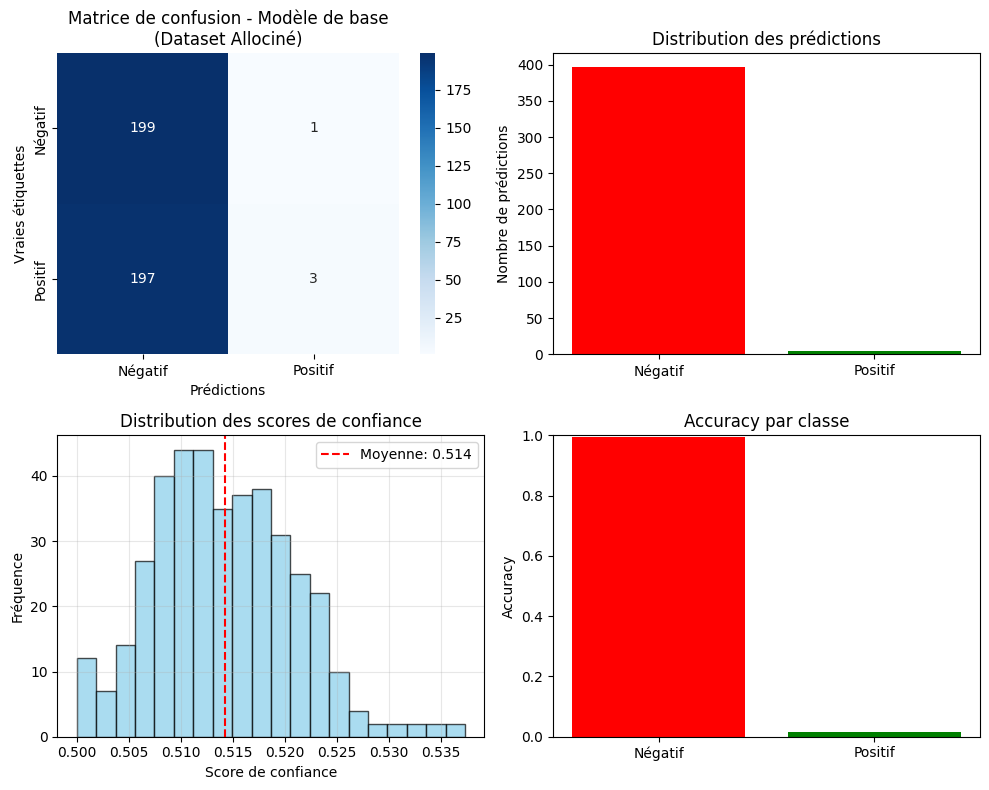


 Rapport de classification détaillé :
              precision    recall  f1-score   support

     Négatif      0.503     0.995     0.668       200
     Positif      0.750     0.015     0.029       200

    accuracy                          0.505       400
   macro avg      0.626     0.505     0.349       400
weighted avg      0.626     0.505     0.349       400



In [7]:
# ============================================================================
# ANALYSE DÉTAILLÉE DES RÉSULTATS
# ============================================================================

print("\n" + "="*60)
print(" ANALYSE DÉTAILLÉE")
print("="*60)

# Matrice de confusion
cm = confusion_matrix(test_labels, baseline_results['predictions'])
print(f"\n Matrice de confusion :")
print("    Prédictions →")
print("Réel ↓   Nég  Pos")
for i, row in enumerate(cm):
    label_name = label_mapping[i][:3]
    print(f"{label_name}     {row[0]:3d}  {row[1]:3d}")

# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 8))

# Matrice de confusion
plt.subplot(2, 2, 1)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=['Négatif', 'Positif'],
            yticklabels=['Négatif', 'Positif'],
            cmap='Blues')
plt.title('Matrice de confusion - Modèle de base\n(Dataset Allociné)')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')

# Distribution des prédictions
plt.subplot(2, 2, 2)
pred_counts = pd.Series(baseline_results['predictions']).value_counts().sort_index()
labels = [label_mapping[i] for i in pred_counts.index]
plt.bar(labels, pred_counts.values, color=['red', 'green'])
plt.title('Distribution des prédictions')
plt.ylabel('Nombre de prédictions')

# Scores de confiance
plt.subplot(2, 2, 3)
confidences = []
for scores in baseline_results['all_scores']:
    max_conf = max(scores.values())
    confidences.append(max_conf)

plt.hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(confidences), color='red', linestyle='--',
           label=f'Moyenne: {np.mean(confidences):.3f}')
plt.xlabel('Score de confiance')
plt.ylabel('Fréquence')
plt.title('Distribution des scores de confiance')
plt.legend()
plt.grid(True, alpha=0.3)

# Performance par classe
plt.subplot(2, 2, 4)
class_metrics = []
for label_id in [0, 1]:
    mask = np.array(test_labels) == label_id
    if mask.sum() > 0:
        class_predictions = np.array(baseline_results['predictions'])[mask]
        class_accuracy = (class_predictions == label_id).mean()
        class_metrics.append(class_accuracy)
    else:
        class_metrics.append(0)

plt.bar([label_mapping[i] for i in [0, 1]], class_metrics, color=['red', 'green'])
plt.title('Accuracy par classe')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Rapport de classification détaillé
print(f"\n Rapport de classification détaillé :")
class_names = ['Négatif', 'Positif']
report = classification_report(
    test_labels,
    baseline_results['predictions'],
    target_names=class_names,
    digits=3
)
print(report)

In [8]:
# ============================================================================
# ANALYSE DES ERREURS
# ============================================================================

print("\n" + "="*60)
print(" ANALYSE DES ERREURS")
print("="*60)

# Créer un DataFrame avec les résultats
results_df = test_df.copy()
results_df['predicted'] = baseline_results['predictions']
results_df['correct'] = results_df['label'] == results_df['predicted']

# Ajouter les scores de confiance
confidences = [max(scores.values()) for scores in baseline_results['all_scores']]
results_df['confidence'] = confidences

# Avis mal classifiés
wrong_predictions = results_df[~results_df['correct']]
correct_predictions = results_df[results_df['correct']]

print(f" Erreurs de classification :")
print(f"   Prédictions correctes: {len(correct_predictions)}/{len(results_df)} ({len(correct_predictions)/len(results_df)*100:.1f}%)")
print(f"   Prédictions incorrectes: {len(wrong_predictions)}/{len(results_df)} ({len(wrong_predictions)/len(results_df)*100:.1f}%)")

# Exemples d'erreurs par catégorie
print(f"\n Exemples d'erreurs :")
for true_label in [0, 1]:
    errors_for_label = wrong_predictions[wrong_predictions['label'] == true_label]
    if len(errors_for_label) > 0:
        print(f"\n{label_mapping[true_label]} mal classifiés comme {label_mapping[1-true_label]} :")
        for idx, row in errors_for_label.head(2).iterrows():
            text_preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
            print(f"  • \"{text_preview}\"")
            print(f"    → Confiance: {row['confidence']:.3f}")

# Exemples de bonnes prédictions
print(f"\n Exemples de prédictions correctes :")
for true_label in [0, 1]:
    correct_for_label = correct_predictions[correct_predictions['label'] == true_label]
    if len(correct_for_label) > 0:
        # Prendre les plus confiantes
        best_correct = correct_for_label.nlargest(2, 'confidence')
        print(f"\n{label_mapping[true_label]} bien classifiés :")
        for idx, row in best_correct.iterrows():
            text_preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
            print(f"  • \"{text_preview}\"")
            print(f"    → Confiance: {row['confidence']:.3f}")


 ANALYSE DES ERREURS
 Erreurs de classification :
   Prédictions correctes: 202/400 (50.5%)
   Prédictions incorrectes: 198/400 (49.5%)

 Exemples d'erreurs :

Négatif mal classifiés comme Positif :
  • "Le documentaire de Jean-Pierre Thorn est original car il s'intéresse de près au département de la Se..."
    → Confiance: 0.501

Positif mal classifiés comme Négatif :
  • "Film cultissime de Disney, May Poppins a marqué son temps et toute une génération de spectateurs. Po..."
    → Confiance: 0.506
  • "Un grand film français ciselé avec des dialogues très bien écrits....des acteurs peu connus mais tal..."
    → Confiance: 0.515

 Exemples de prédictions correctes :

Négatif bien classifiés :
  • "Le film se laisse voir mais c'est quand même assez moyen, le point positif c'est qu'il est court et ..."
    → Confiance: 0.537
  • "Très déçue par cette 2e partie qui est alourdie par cette lecture qui n'en finit pas, moins d'intérê..."
    → Confiance: 0.535

Positif bien classifiés :
  •

In [9]:
# ============================================================================
# ANALYSE DE LA CONFIANCE DU MODÈLE
# ============================================================================

print("\n" + "="*60)
print(" ANALYSE DE LA CONFIANCE DU MODÈLE")
print("="*60)

avg_confidence = np.mean(confidences)
avg_confidence_correct = correct_predictions['confidence'].mean() if len(correct_predictions) > 0 else 0
avg_confidence_wrong = wrong_predictions['confidence'].mean() if len(wrong_predictions) > 0 else 0

print(f" Confiance moyenne globale: {avg_confidence:.3f}")
print(f" Confiance sur prédictions correctes: {avg_confidence_correct:.3f}")
print(f" Confiance sur prédictions incorrectes: {avg_confidence_wrong:.3f}")

confidence_gap = avg_confidence_correct - avg_confidence_wrong
print(f" Écart de confiance (correct vs incorrect): {confidence_gap:.3f}")

if confidence_gap > 0.1:
    print(" Le modèle est plus confiant sur ses bonnes prédictions")
else:
    print(" Le modèle a des difficultés à évaluer sa propre confiance")


 ANALYSE DE LA CONFIANCE DU MODÈLE
 Confiance moyenne globale: 0.514
 Confiance sur prédictions correctes: 0.515
 Confiance sur prédictions incorrectes: 0.514
 Écart de confiance (correct vs incorrect): 0.001
 Le modèle a des difficultés à évaluer sa propre confiance


In [11]:
# ============================================================================
# SAUVEGARDE DES RÉSULTATS DE BASE
# ============================================================================

print("\n" + "="*60)
print("SAUVEGARDE DES RÉSULTATS")
print("="*60)

# Sauvegarder les résultats détaillés
results_df.to_csv('baseline_results_allocine.csv', index=False)

# Sauvegarder les métriques
baseline_metrics = {
    'model_name': model_name,
    'dataset': 'allocine',
    'test_size': len(test_df),
    'accuracy': baseline_results['accuracy'],
    'precision': baseline_results['precision'],
    'recall': baseline_results['recall'],
    'f1': baseline_results['f1'],
    'avg_confidence': avg_confidence,
    'avg_confidence_correct': avg_confidence_correct,
    'avg_confidence_wrong': avg_confidence_wrong
}

import json
with open('baseline_metrics_allocine.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

print(f" Résultats sauvegardés :")
print(f"   • baseline_results_allocine.csv : prédictions détaillées")
print(f"   • baseline_metrics_allocine.json : métriques de performance")


SAUVEGARDE DES RÉSULTATS
 Résultats sauvegardés :
   • baseline_results_allocine.csv : prédictions détaillées
   • baseline_metrics_allocine.json : métriques de performance


In [12]:
# ============================================================================
# RÉCAPITULATIF
# ============================================================================

print("\n" + "="*60)
print(" RÉCAPITULATIF DE L'ÉVALUATION BASELINE")
print("="*60)

print(f" Modèle évalué: {model_name}")
print(f" Dataset: Allociné ({len(test_df)} avis de test)")
print(f" Performance baseline :")
print(f"   • Accuracy: {baseline_results['accuracy']*100:.1f}%")
print(f"   • F1-Score: {baseline_results['f1']:.3f}")
print(f"   • Confiance moyenne: {avg_confidence:.3f}")







 RÉCAPITULATIF DE L'ÉVALUATION BASELINE
 Modèle évalué: distilbert-base-multilingual-cased
 Dataset: Allociné (400 avis de test)
 Performance baseline :
   • Accuracy: 50.5%
   • F1-Score: 0.349
   • Confiance moyenne: 0.514
